In [1]:
%pip install -qU langchain langchain-google-genai langchain_community tavily-python aiosqlite langchain-tavily 
%pip install -qU langgraph-checkpoint-sqlite 
%pip install -qU langgraph langgraph-checkpoint-sqlite
%pip install -qU langgraph 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
import sqlite3 
from langgraph.checkpoint.sqlite import SqliteSaver 
conn = sqlite3.connect("checkpoints.db", check_same_thread=False) 
memory = SqliteSaver(conn)

In [3]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') 
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

d:\Videos - Cursos\TIME_LATAM\Alvaro\Videos_2255\MULTIAGENTES_LANGGRAPH\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_24604\393494481.py:1: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [4]:
from typing import TypedDict, List

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [6]:
PLAN_PROMPT = """Eres un escritor especialista con la tarea de crear un esquema de alto nivel para una redacción. \
Escribe este esquema para el tema proporcionado por el usuario. Presenta un plan de la redacción junto con cualesquiera notas \
o instrucciones relevantes para las secciones."""

In [7]:
WRITER_PROMPT = """Eres un asistente de redacción con la tarea de escribir excelentes redacciones de 5 párrafos. \
Genera la mejor redacción posible para la solicitud del usuario y el esquema inicial. \
Si el usuario proporciona críticas, responde con una versión revisada de tus intentos anteriores. \
Utiliza toda la información a continuación según sea necesario:

------

{content}"""

In [8]:
REFLECTION_PROMPT = """Eres un profesor corrigiendo una redacción presentada. \
Genera una crítica y recomendaciones para la entrega del usuario. \
Proporciona recomendaciones detalladas, incluyendo solicitudes sobre extensión, profundidad, estilo, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """Eres un investigador encargado de proporcionar información que puede \
ser utilizada al escribir la siguiente redacción. Genera una lista de consultas de investigación que \
recopilen cualquier información relevante. Genera como máximo 3 consultas."""

In [10]:
RESEARCH_CRITIQUE_PROMPT = """Eres un investigador encargado de proporcionar información que puede \
ser utilizada al realizar cualquier revisión solicitada (según se describe a continuación). \
Genera una lista de consultas de investigación que recopilen cualquier información relevante. Genera como máximo 3 consultas."""

In [11]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [12]:
import os
from tavily import TavilyClient

tavily = TavilyClient(api_key=TAVILY_API_KEY)

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=memory)


--- Tratando de Generar el PNG del Grafo vía Mermaid (Requiere Playwright!) ---


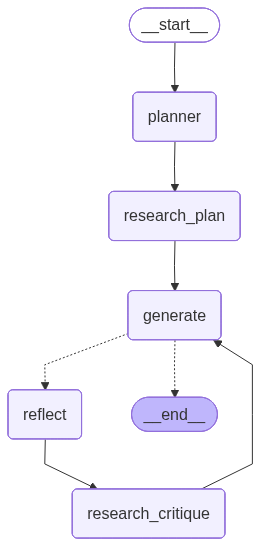

Grafo PNG generado y exhibido con éxito!


In [25]:
from IPython.display import Image, display, Markdown
import os

print("\n--- Tratando de Generar el PNG del Grafo vía Mermaid (Requiere Playwright!) ---")
try:

    image_data = graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))
    print("Grafo PNG generado y exhibido con éxito!")

except Exception as e:

    print(f"\nError al tratar de generar el PNG del grafo: {e}")
    print("Esto posiblemente se debe a que:")
    print("1. El método `.draw_mermaid_png()` no existe en su versión de LangGraph.")
    print("2. Faltan dependencias como 'playwright' o sus drivers no fueron instalados.")
    print("   Trata con: pip install playwright && playwright install")
    print("3. Otro error inesperado al acceder al grafo o renderizar.")

    print("\n--- Tratando generar únicamente el código Mermaid (Fallback) ---")
    try:

        mermaid_code = graph.get_graph().draw_mermaid()
        print("\n--- Código Mermaid Generado (Pégalo en https://mermaid.live/ o utiliza Markdown en tu notebook) ---")
        print(mermaid_code)

    except Exception as e_mermaid:
        print(f"Error al generar el código Mermaid: {e_mermaid}")
        print("Verifica si 'graph.get_graph()' está correcto y es accesible.")

In [26]:
thread = {"configurable": {"thread_id": "5"}}
for s in graph.stream({
    'task': "Cuál es la diferencia entre LangChain y LangSmith",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [], 
}, thread):
    print(s)

{'planner': {'plan': '¡Excelente tema! La diferencia entre LangChain y LangSmith es un punto clave de confusión para muchos desarrolladores en el espacio de las LLMs. Ambos son productos de la misma compañía (LangChain, Inc.) y están diseñados para trabajar juntos, pero cumplen funciones muy distintas.\n\nAquí tienes un esquema de alto nivel para una redacción que explica esta diferencia, junto con notas e instrucciones:\n\n---\n\n## Esquema de Redacción: LangChain vs. LangSmith - Una Guía para Entender sus Diferencias y Complementariedad\n\n**Tema Principal:** Clarificar la distinción entre LangChain (marco de desarrollo) y LangSmith (plataforma de observabilidad y evaluación) y cómo se complementan en el ciclo de vida de una aplicación LLM.\n\n---\n\n### I. Introducción\n\n*   **Gancho:** El auge de los Modelos de Lenguaje Grandes (LLMs) ha abierto un sinfín de posibilidades, pero también ha introducido complejidades en su desarrollo, depuración y puesta en producción.\n*   **Context